# GEOPH 559: Geophysical Fluid Dynamics
### Modeling Geophysical Flows: 1-D Advection Modeling

The purpose of this notebook is to provide an approachable introduction to numerical modeling of geophysical fluid dynamics. Throughout GFD we develop descriptions of the dynamics of geophysical fluid flows in the form of partial differential equations. Much of the time, particularly in the case of the full Navier-Stokes equations, these descriptions do not have known, closed-form, analytical solutions. Sometimes we can make assumptions that allow us to neglect or remove terms from the N-S equations and then find analytical solutions. Sometimes, as is the case with phenomena like geostrophic flow or the thermal wind these approximations provide asymptotic approximations to things we actually observe in the Earth system. 

Outside of these special cases, however, we require an approximate solution to forms of the N-S equations under given initial and boundary conditions. To do this, we require a numerical model that solves a discretized form of the (even still often simplified) Navier-Stokes equations. In this unit of the class, we explore this through the lens of the 1-D advection equation, written as:

$$ 
\frac{\partial S}{\partial t} + u \cdot \frac{\partial S}{\partial x} = 0,
$$

where $S$ is some conservative tracer or scalar quantity (we'll use salinity and will discuss below part of the rationale), $t$ is time, $u$ is the advection velocity (e.g., the speed of the transporting fluid), and $x$ is distance. 

In class, we developed a finite difference approximation to the 1-D advection equation that was a forward-time, *upwind* solution. That solution looked like the following:

$$
S_j^{i+1} = S_j^i - \frac{u \Delta t}{\Delta x}(S_j^i - S_{j-1}^i)
$$

This approximation assumes that the flow is always from left-to-right, which is necessary for stability. If flow was from right-to-left (i.e., in the negative $x$ direction), we could have performed a *downwind* differencing. Further, as we can see from this equation, we need to know the salinity at location $j=0$ for all times, as there is no location $j=-1$. This is our __boundary condition__. Similarly, we need to know the salinity everywhere in our domain at time $i=0$, as there is no time $i=-1$. This is our __initial condition__. 

The solution to the 1-D advection equation developed below is a more general solution that allows for the possibility of flow from right-to-left, referred to as the [Lax-Wendroff](https://en.wikipedia.org/wiki/Lax%E2%80%93Wendroff_method) scheme.   

### 1. Import Libraries, Define Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
%matplotlib inline

output_every = 10 # this controls how time steps to skip in making the animation. Lower = larger animations 

# ----------------------------
# Domain parameters
# ----------------------------
L = 1000e3  # length of the domain in (m)
nx = 500    # number of spatial points
dx = L / (nx - 1)
x = np.linspace(0, L, nx)
x_km = x/1e3 # create a vector of distance in km for plotting

# ----------------------------
# Advection parameters
# ----------------------------
u = 1.5     # advection speed (m/s)
dt = 1000   # time step (s)
nt = 300    # number of time steps
t = np.linspace(0, (nt+1)*dt, nt+1)

# Check for numerical stability. Note: Explore what happens when you exceed c = 1
c = u * dt / dx  # Courant number

print(f'Courant number: {c:.2f}')
if c > 1:
    print('Warning: Courant number exceeds stability limit! Consider reducing timestep or increasing spatial step')


Courant number: 0.75


### 2. Define Initial Conditions

Initial conditions in this notebook correspond to a positive sea surface salinity anomaly that takes the form of a Gaussian shaped "bump" in the modeling domain. A side discourse on the significance of salinty (and salt transport) to oceanic currents and why we're interested in salt transport. One particular process that can lead to increases in sea surface salinity is evaporation. As water evaporates from the ocean surface, salt is left behind and places where evaporation happens at a faster rate tend to be associated with higher surface salinity. As such, anomalies in sea surface salinity can develop in places where evaporation is faster in a climatological sense (i.e., portions of the ocean that are net sinks of water and evaporation exceeds precipitation) and in a synoptic sense (i.e., places that have recently encountered increased evaporation from, for example, the passing of a tropical cyclone). Additionally, sea surface salinity is a property that can be remotely sensed in a variety of wavelengths in the electromagnetic spectrum, but particularly in the microwave. For example, the European Space Agency's [Soil Moisture and Ocean Salinity (SMOS)](https://earth.esa.int/eogateway/missions/smos) satellite leverages the fact that salinity influences microwave emission in the L-band (~1.4 GHz) to retrieve ocean salinity at the surface. Additionally, the image below illustrates how Hurricane Irma left behind a "hurricane wake" of high salinity in 2017 as it intensified from a Category 3 to 5 storm in the Carribbean. For more information on this image, see this [AGU Eos](https://eos.org/editor-highlights/hurricanes-wakes-show-asymmetrical-response-in-ocean-salinity) article.  

![The sea surface salinity response to Hurricane Irma (2017) shows the tropical Atlantic Ocean becomes saltier (reds) on the right-hand side of the storm track (line of dots) compared to the left hand side, especially when the storm was reaching Category 5 (pink dots). The legend shows storm strengths including tropical depression (TD), tropical storm (TS) and hurricane strength categories 1-5. Credit: Reul et al. [2021], Figure 1a](images/2020GL091478-Figure-1a-sized-for-Eos.png)

<function matplotlib.pyplot.show(close=None, block=None)>

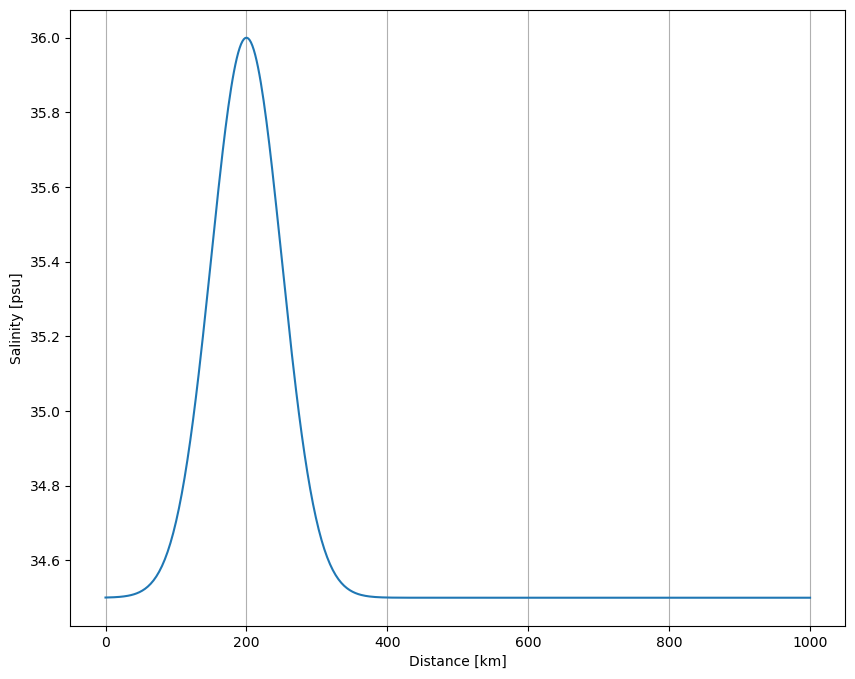

In [2]:
# ----------------------------
# Initial conditions
# ----------------------------

# Background salinity
background_salinity = 34.5  # Practical salinity units (psu), equivalent to parts per thousand
peak_salinity = 36.0 # psu
anomaly_center = 200e3 # location of anomaly center (m)
anomaly_width = 50e3 # width of anomaly as a standard deviation in a gaussian (m)

# Initial condition: Gaussian anomaly
salinity0 = background_salinity + (peak_salinity - background_salinity) * \
            np.exp(-((x - anomaly_center)**2) / (2 * anomaly_width**2))
    
plt.figure(figsize=(10,8))
plt.plot(x_km,salinity0)
plt.xlabel('Distance [km]')
plt.ylabel('Salinity [psu]')
plt.grid(axis='x')
plt.show

### 3. Define Lax-Wendroff solution

The following is a function that takes as input the vector of salinity values in the domain at the current time step and the courant number (i.e., $u\Delta t / \Delta x$), and returns the Lax-Wendroff estimate of the salinity values in the domain at the next time step. In the main "time loop" below, this equation is called at each time step with the value of salinity at the current time step.

In [3]:
# ----------------------------
# Lax-Wendroff function
# ----------------------------
def lax_wendroff(salinity, c):
    s_new = salinity.copy()
    for i in range(1, len(salinity) - 1):
        s_new[i] = (salinity[i] 
                    - 0.5 * c * (salinity[i + 1] - salinity[i - 1]) 
                    + 0.5 * c**2 * (salinity[i + 1] - 2 * salinity[i] + salinity[i - 1]))
    return s_new

### 4. Integrate the 1-D Advection Equation

Having defined the initial and boundary conditions, and having defined the Lax-Wendroff function, we can now step through each time step and calculate the salinity at each spatial location $j$. 

In [4]:
# ----------------------------
# Time loop
# ----------------------------
salinity = salinity0
salinity_record = np.zeros((nx,nt+1))
salinity_record[:,0] = salinity

for n in range(nt):
    salinity = lax_wendroff(salinity, c)
    salinity[0] = background_salinity      # fixed left boundary
    salinity[-1] = background_salinity     # fixed right boundary
    salinity_record[:,n+1] = salinity


### 5. Create an Animation

Let's create an animated GIF of the advection of our salinity anomaly over the course of the simulation. Open the GIF in another window. What is happening and does this make sense?

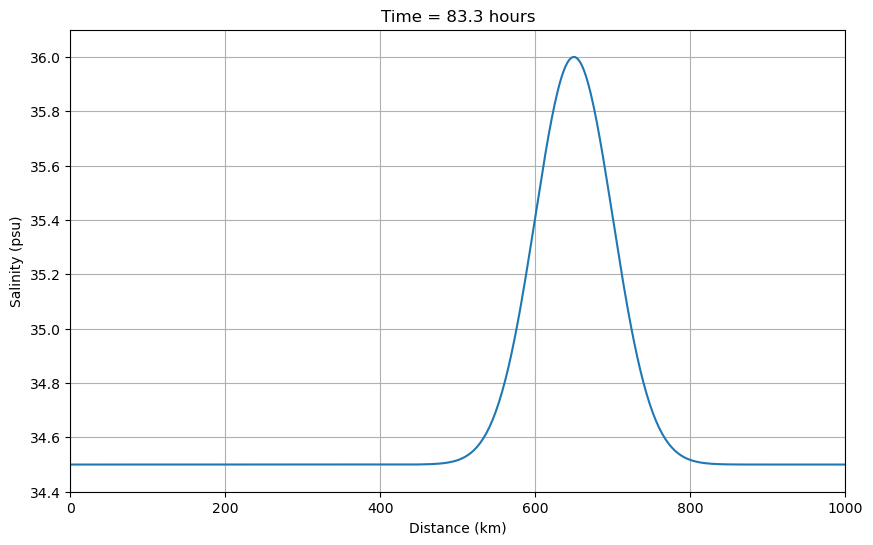

In [5]:
# ----------------------------
# Animation
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot(x_km, salinity0, label='Salinity')
ax.set_ylim(34.4, 36.1)
ax.set_xlim(x_km.min(), x_km.max())
ax.set_xlabel("Distance (km)")
ax.set_ylabel("Salinity (psu)")
ax.set_title("1D Advection of Salinity (Lax-Wendroff Scheme)")
ax.grid(True)

def update(frame):
    line.set_ydata(salinity_record[:,frame])
    ax.set_title(f"Time = {frame*dt/3600:.1f} hours")
    return line,

anim = FuncAnimation(fig, update, frames=range(0, nt+1, output_every), interval=50)
anim.save("salinity_animation.gif", writer=PillowWriter(fps=60))
plt.show()


### 6. Plot Salinity Through Time

This plot is a plot of salinity in the middle of the domain (i.e., at a location of approximately 500 km in our domain) through time. A couple of reflection questions:

* What can you say qualitatively about the behavior of salinity at this location?
* Is the arrival time of the salinity anomaly as expected? Can you do some back-of-the-envelope calculations about when the beginning or peak of the anomaly should have arrived and is this consistent with the model results?  

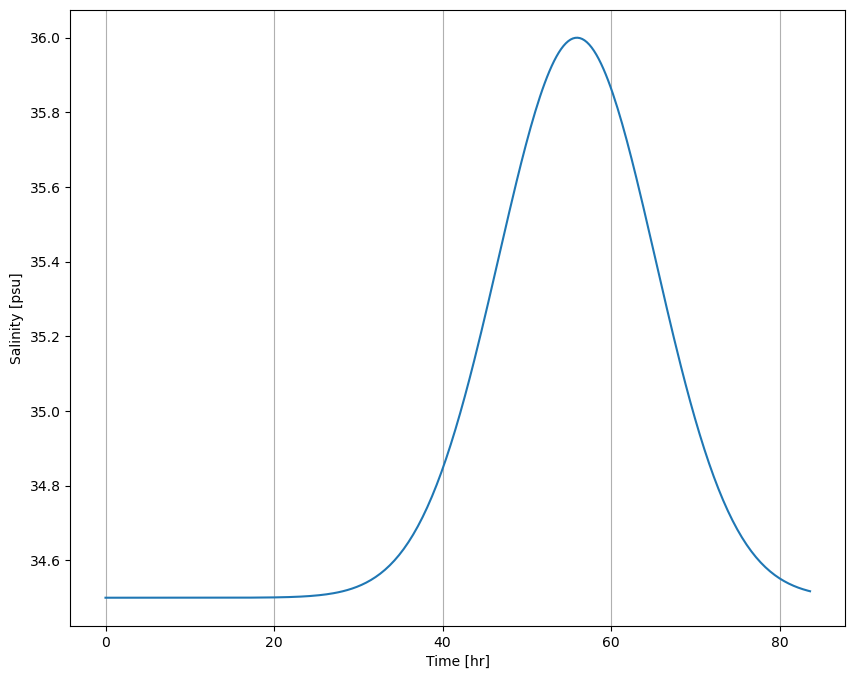

In [6]:
plt.figure(figsize=(10,8))
plt.plot(t/3600,salinity_record[int(nx/2),:])
plt.xlabel('Time [hr]')
plt.ylabel('Salinity [psu]')
plt.grid(axis='x')
plt.show()

### 7. Next Steps

Some things to try on your own by modifying the code:

1. We said that Lax-Wendroff should allow for advection in the $-x$ direction. Can you verify this? 
2. We haven't said much about the Courant condition, $c = u \Delta t/ \Delta x$, other than there being a warning that it should be less than 1. What happens if you select a time step consistent with $c > 1$? Does the behavior look reasonable and is it real?

Some things to think about vis-a-vis the realism of this notebook
* Related to the above, this notebook is entirely for a pure advection process. Mechanical dispersion (and, to a lesser extent, molecular diffusion) are also present in the transport of materials. Qualitatively, how would diffusion change our solution?
* This advection notebook assumes a conservative tracer, meaning that the mass of our tracer is conserved. How could we verify whether or not our solution is conserving mass? Are there natural processes that remove salt from the ocean? How might we represent these processes? 
* In this notebook, the velocity $u$ is spatiotemporally constant. What does $u$ correspond to in the "real" ocean and where might the numbers come from in a more sophisticated model?
